In [59]:
import json
import requests
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # matplotlib is not installed automatically
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

In [60]:
network_name = 'California'

input_path = r"..\1_data"
appeears_path = r"APPEEARS_subsetting"
SMAPL3_path = r"SPL3SMP_E"
SMAPL4_path = r"SPL4SMGP"
SMAPL4_grid_path = r"SMAPL4SMGP_EASEreference"
MODIS_path = r"MOD15A2H"
PET_path = r"PET"

## Read and process data

### Request json

In [61]:
file_path = os.path.join(input_path, appeears_path, network_name, f'{network_name}-request.json')
with open(file_path, 'r') as infile:
    request_content = json.load(infile)

coordinates = request_content['params']['coordinates']

coordinate = 0
target_lat = coordinates[coordinate]['latitude']
target_lon = coordinates[coordinate]['longitude']
target_station = coordinates[coordinate]['category']
print(f'Currently processing station: {target_station}')

output_path = os.path.join(r".\3_data_out", target_station)
if not os.path.exists(output_path):
    os.makedirs(output_path)

Currently processing station: Central_valley


### SMAP L3

In [62]:
file_path = os.path.join(input_path, appeears_path, network_name, f'{network_name}-SPL3SMP-E-005-results.csv')
SMAPL3_pt_sample = pd.read_csv(file_path)
SMAPL3_pt_sample = SMAPL3_pt_sample[(SMAPL3_pt_sample['Latitude'] == target_lat) & (SMAPL3_pt_sample['Longitude'] == target_lon)].copy()

df_ts_smap_am = SMAPL3_pt_sample[['Date', 'SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_soil_moisture','SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag']].copy()
df_ts_smap_am['Date'] = pd.to_datetime(df_ts_smap_am['Date'])
df_ts_smap_am.set_index('Date', inplace=True)
bad_data_idx_smap = df_ts_smap_am[(df_ts_smap_am['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag'] != 0.0) & (df_ts_smap_am['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag'] != 8.0)].index
df_ts_smap_am.drop(bad_data_idx_smap, inplace=True)
df_ts_smap_am_daily = df_ts_smap_am['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_soil_moisture'].resample('D', axis=0).mean()

df_ts_smap_pm = SMAPL3_pt_sample[['Date', 'SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm','SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm']].copy()
df_ts_smap_pm['Date'] = pd.to_datetime(df_ts_smap_pm['Date'])
df_ts_smap_pm.set_index('Date', inplace=True)
bad_data_idx_smap = df_ts_smap_pm[(df_ts_smap_pm['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm'] != 0.0) & (df_ts_smap_pm['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm'] != 8.0)].index
df_ts_smap_pm.drop(bad_data_idx_smap, inplace=True)
df_ts_smap_pm_daily = df_ts_smap_pm['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm'].resample('D', axis=0).mean()

df_ts_sync = pd.merge(df_ts_smap_am_daily, df_ts_smap_pm_daily, how='inner', left_index=True, right_index=True)
df_ts_sync['soil_moisture_smapL3'] = df_ts_sync[['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_soil_moisture','SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm']].mean(axis=1, skipna=True)
df_ts_sync['soil_moisture_smapL3'] = df_ts_sync['soil_moisture_smapL3'].resample('D', axis=0).mean()

### SMAPL4

In [63]:
file_path = os.path.join(input_path, appeears_path, network_name, f'{network_name}-SPL4SMGP-006-results.csv')
SMAPL4_pt_sample = pd.read_csv(file_path)
SMAPL4_pt_sample = SMAPL4_pt_sample[(SMAPL4_pt_sample['Latitude'] == target_lat) & (SMAPL4_pt_sample['Longitude'] == target_lon)].copy()
# print(SMAPL4_pt_sample.columns)

# SMAPL4_pt_sample[['SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_0', 
#                   'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_1',
#                   'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_2',
#                   'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_3',
#                   'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_4',
#                   'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_5',
#                   'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_6',
#                   'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_7']].plot()

# ? Where is data converted to daily from hourly? 

df_ts_smap_precip = SMAPL4_pt_sample[['Date', 'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_0']].copy()
df_ts_smap_precip = df_ts_smap_precip.rename({'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_0': 'precip'}, axis='columns')
df_ts_smap_precip['Date'] = pd.to_datetime(df_ts_smap_precip['Date'])
df_ts_smap_precip.set_index('Date', inplace=True)
df_ts_smap_precip

,precip
Date,
2015-03-31,0.000000
2015-04-01,0.000000
2015-04-02,0.000000
2015-04-03,0.000000
2015-04-04,0.000000
...,...
2022-03-26,0.000000
2022-03-27,0.000000
2022-03-28,0.000000


Convert precipitation from kg/m2/s to mm/day -> 1 kg/m2/s = 86400 mm/day

In [64]:
df_ts_smap_precip = df_ts_smap_precip * 86400

In [65]:
df_ts_sync = pd.merge(df_ts_sync, df_ts_smap_precip, how='inner', left_index=True, right_index=True)

noprecip = df_ts_smap_precip['precip'] < 0.00002
df_ts_sync['noprecip'] = noprecip

df_ts_sync.head()

,SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_soil_moisture,SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm,soil_moisture_smapL3,precip,noprecip
Date,,,,,
2015-04-03,0.080593,NaN,0.080593,0.0,True
2015-04-04,NaN,0.052842,0.052842,0.0,True
2015-04-05,0.073338,NaN,0.073338,0.0,True
2015-04-06,0.082093,NaN,0.082093,0.0,True
2015-04-07,NaN,0.050903,0.050903,0.0,True


<AxesSubplot: xlabel='Date'>

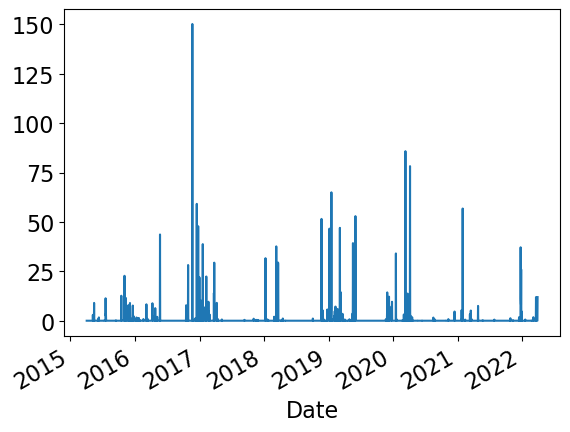

In [66]:
df_ts_sync['precip'].plot()

### PET

Get the point-sampled PET data beforehand by running '0_code\singerPET_create_datarods_v3.py'

In [7]:
file_path = os.path.join(input_path, PET_path, target_station)
file_list = os.listdir(file_path)

print(file_list)
PET = pd.read_csv(os.path.join(file_path, file_list[0]), header=None)
day_num = PET.index.to_numpy()
year = file_list[0][-8:-4]
PET['Date'] = pd.to_datetime(PET.index, unit='D', origin=pd.Timestamp(year))
PET.set_index('Date', inplace=True)

for i, file in enumerate(file_list):
    PET = pd.read_csv(os.path.join(file_path, file), header=None)
    year = file[-8:-4]
    PET['Date'] = pd.to_datetime(PET.index, unit='D', origin=pd.Timestamp(year))
    PET.set_index('Date', inplace=True)
    if i==0:
        ds_PET = PET
    else:
        ds_PET = pd.concat([ds_PET, PET])
ds_PET = ds_PET.sort_index()
ds_PET = ds_PET.rename(columns = {0:'PET'})
ds_PET

FileNotFoundError: [WinError 3] The system cannot find the path specified: '..\\1_data\\PET\\Central_valley'

In [8]:
ds_synced = pd.merge(df_ts_sync[['soil_moisture_smapL3', 'precip']], ds_PET, how='inner', left_index=True, right_index=True)
ds_synced = ds_synced.rename({'soil_moisture_smapL3': 'soil_moisture_daily'}, axis='columns')
ds_synced

NameError: name 'ds_PET' is not defined

Workaround while internet is down

In [141]:
# Workaround while internet is down
# ds_synced = pd.merge(df_ts_sync[['soil_moisture_smapL3', 'precip']], ds_PET, how='inner', left_index=True, right_index=True)
ds_synced = df_ts_sync[['soil_moisture_smapL3', 'precip']]
ds_synced = ds_synced.rename({'soil_moisture_smapL3': 'soil_moisture_daily'}, axis='columns')
ds_synced

,soil_moisture_daily,precip
Date,,
2015-04-03,0.080593,0.00000
2015-04-04,0.052842,0.00000
2015-04-05,0.073338,0.00000
2015-04-06,0.082093,0.00000
2015-04-07,0.050903,0.00000
...,...,...
2022-03-25,0.076851,0.00000
2022-03-26,0.109255,0.00000
2022-03-27,0.079964,0.00000


## Calculate dSdt

In [142]:
# Thresholds
lower_quantile_thresh = 0.25
upper_quantile_thresh = 0.75
precip_thresh = 0.00002

In [143]:
precip_mask = ds_synced['precip'].where(ds_synced['precip'] < precip_thresh)
no_sm_record_but_precip_present = ds_synced['precip'].where((precip_mask.isnull()) & (ds_synced['soil_moisture_daily'].isnull()))
ds_synced['sm_for_dS_calc'] = ds_synced['soil_moisture_daily'].where(no_sm_record_but_precip_present.isnull(), 9999)

In [144]:
# Calculate dS
ds_synced['dS'] = ds_synced['sm_for_dS_calc'].bfill(limit=5).diff().where(ds_synced['sm_for_dS_calc'].notnull().shift(periods=+1))

# Drop the dS where  (precipitation is present) && (soil moisture record does not exist)
ds_synced['dS'] = ds_synced['dS'].where((ds_synced['dS'] > -1) & (ds_synced['dS'] < 1))

# Calculate dt
non_nulls = ds_synced['sm_for_dS_calc'].isnull().cumsum()
nan_length = non_nulls.where(ds_synced['sm_for_dS_calc'].notnull()).bfill()+1 - non_nulls +1
ds_synced['dt'] = nan_length.where(ds_synced['sm_for_dS_calc'].isnull()).fillna(1)

# Calculate dS/dt
ds_synced['dSdt'] = ds_synced['dS']/ds_synced['dt']
ds_synced['dSdt'] = ds_synced['dSdt'].shift(periods=-1)


In [145]:
# Mask where precipitation is on the day 1 of soil moisture measruement
# ds_synced['dSdt'] = ds_synced['dSdt'].where(precip_mask.notnull())

In [146]:
ds_synced.head()

,soil_moisture_daily,precip,sm_for_dS_calc,dS,dt,dSdt
Date,,,,,,
2015-04-03,0.080593,0.0,0.080593,NaN,1.0,-0.027751
2015-04-04,0.052842,0.0,0.052842,-0.027751,1.0,0.020496
2015-04-05,0.073338,0.0,0.073338,0.020496,1.0,0.008755
2015-04-06,0.082093,0.0,0.082093,0.008755,1.0,-0.031190
2015-04-07,0.050903,0.0,0.050903,-0.031190,1.0,0.142930


## Detect significant peak

In [179]:
# dSdt_thresh = (ds_synced.soil_moisture_daily.max() - ds_synced.soil_moisture_daily.min()) * 0.1
dSdt_thresh = 0.03

In [180]:
# ds_synced['event_start'] = ds_synced.dSdt > dSdt_thresh
ds_synced['event_start'] = (ds_synced.dSdt) < dSdt_thresh * -1
# ds_synced['event_start'] = ds_synced['event_start'].shift(+1)

In [181]:
ds_synced

,soil_moisture_daily,precip,sm_for_dS_calc,dS,dt,dSdt,event_start,event_end,dS_nonull
Date,,,,,,,,,
2015-04-09,0.126924,0.00000,0.126924,0.004901,1.0,-0.021711,False,False,-0.021711
2015-04-10,0.105213,0.00000,0.105213,0.006651,1.0,-0.004836,False,False,-0.004836
2015-04-11,0.100377,0.00000,0.100377,-0.037961,1.0,-0.030174,True,False,-0.030174
2015-04-12,0.070203,0.00000,0.070203,0.034230,1.0,0.004901,False,False,0.004901
2015-04-13,0.075105,0.00000,0.075105,-0.019769,1.0,0.006651,False,False,0.006651
...,...,...,...,...,...,...,...,...,...
2022-03-25,0.076851,0.00000,0.076851,0.199422,1.0,0.032404,False,False,0.032404
2022-03-26,0.109255,0.00000,0.109255,NaN,1.0,-0.029291,False,False,-0.029291
2022-03-27,0.079964,0.00000,0.079964,NaN,1.0,-0.008262,False,False,-0.008262


In [182]:
# iterate through each row to find event end
precip_thresh = 2
event_end = np.zeros(ds_synced.shape[0], dtype=bool)
ds_synced['dS'] = ds_synced['dS'].shift(-1)
for i in range(1, ds_synced.shape[0]):
    if ds_synced['event_start'][i]:
        start_index = i
        for j in range(i+1, ds_synced.shape[0]):
            if np.isnan(ds_synced['dS'][j]):
                continue
            if ds_synced['dS'][j] >= dSdt_thresh or ds_synced['precip'][j] > precip_thresh:
                event_end[j] = True
                break

# create a new column for event_end
ds_synced['event_end'] = event_end

In [183]:
ds_synced['dS_nonull'] = ds_synced['soil_moisture_daily'].bfill(limit=5).diff()

In [184]:
# iterate through each row to find event end
precip_thresh = 2
event_end = np.zeros(ds_synced.shape[0], dtype=bool)
ds_synced['dS_nonull'] = ds_synced['dS_nonull'].shift(-1)
for i in range(1, ds_synced.shape[0]):
    if ds_synced['event_start'][i]:
        start_index = i
        for j in range(i+1, ds_synced.shape[0]):
            if np.isnan(ds_synced['dS_nonull'][j]):
                None
            if ds_synced['dS_nonull'][j] >= dSdt_thresh or ds_synced['precip'][j] > precip_thresh:
                event_end[j] = True
                break

# create a new column for event_end
ds_synced['event_end'] = event_end

<AxesSubplot: xlabel='Date'>

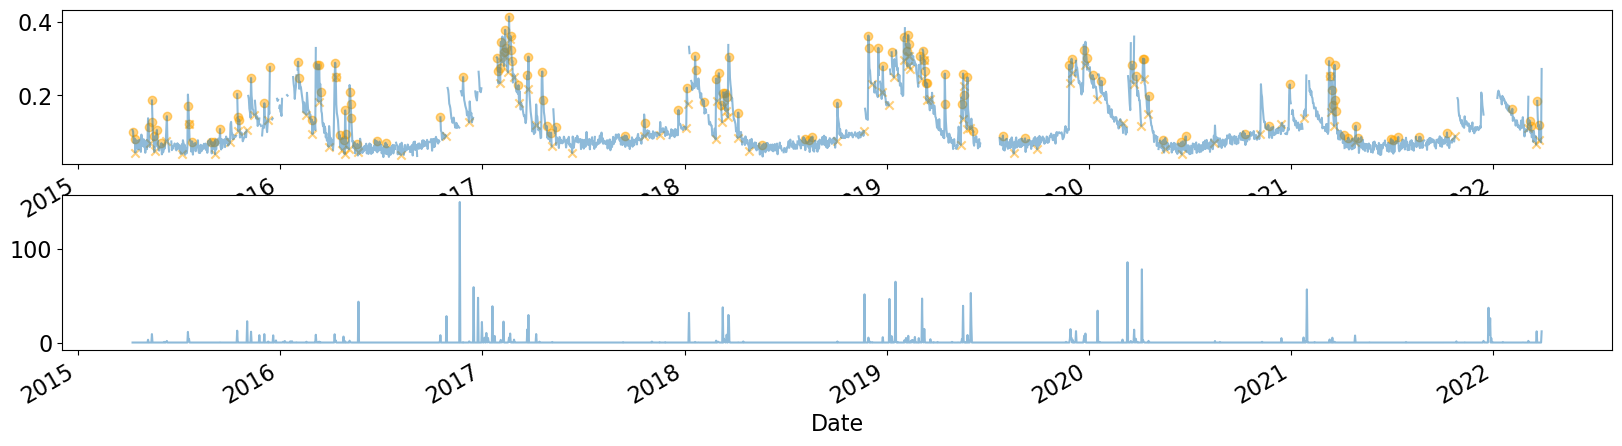

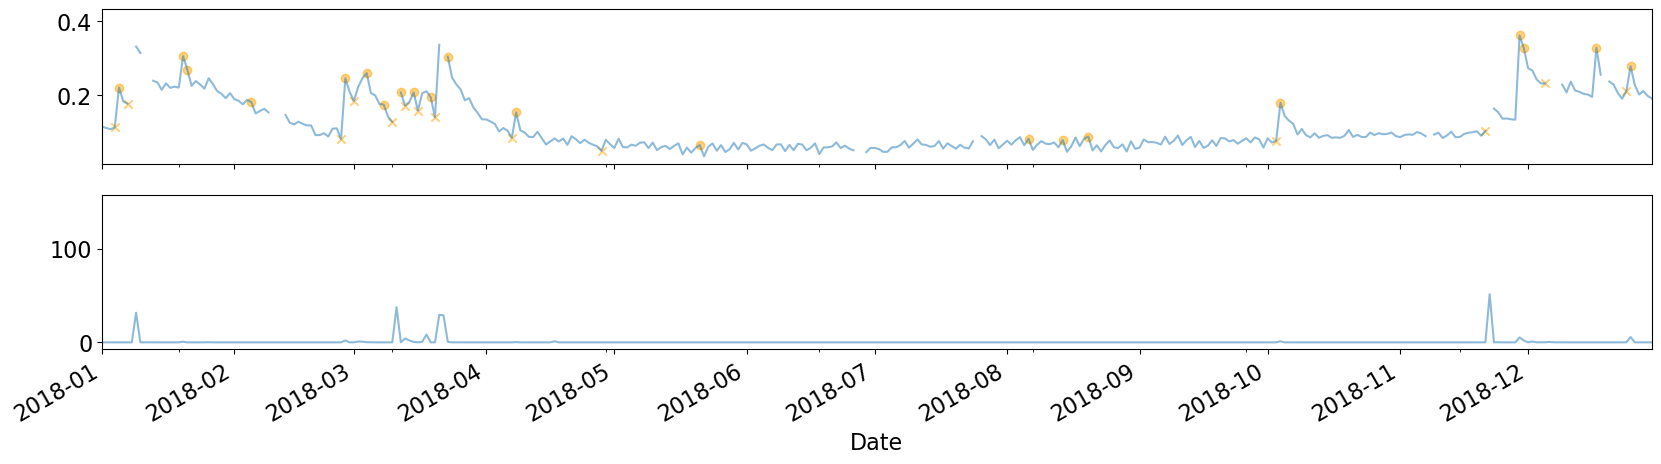

In [185]:
ds_synced = ds_synced[1:]
fig, (ax11, ax12) = plt.subplots(2,1, figsize=(20, 5))
ds_synced.soil_moisture_daily.plot(ax=ax11, alpha=0.5)
ax11.scatter(ds_synced.soil_moisture_daily[ds_synced['event_start']].index, ds_synced.soil_moisture_daily[ds_synced['event_start']].values, color='orange', alpha=0.5)
ax11.scatter(ds_synced.soil_moisture_daily[ds_synced['event_end']].index, ds_synced.soil_moisture_daily[ds_synced['event_end']].values, color='orange', marker='x', alpha=0.5)
ds_synced.precip.plot(ax=ax12, alpha=0.5)

fig2, (ax21, ax22) = plt.subplots(2,1, figsize=(20, 5), sharex=True)
ds_synced.soil_moisture_daily.plot(ax=ax21, alpha=0.5)
ax21.scatter(ds_synced.soil_moisture_daily[ds_synced['event_start']].index, ds_synced.soil_moisture_daily[ds_synced['event_start']].values, color='orange', alpha=0.5)
ax21.scatter(ds_synced.soil_moisture_daily[ds_synced['event_end']].index, ds_synced.soil_moisture_daily[ds_synced['event_end']].values, color='orange', marker='x', alpha=0.5)

ax21.set_xlim([datetime(2018, 1, 1), datetime(2018, 12, 30)])
ds_synced.precip.plot(ax=ax22, alpha=0.5)

In [89]:
# Find the event start and end indices
start_index = None
events = []
for i, row in ds_synced.iterrows():
    if row['dSdt'] > dSdt_thresh:
        if start_index is not None:
            # Found the end of an event
            event = ds_synced.loc[start_index:i]
            events.append(event)
            start_index = None
    elif row['precip'] > 0 or pd.isnull(row['dSdt']):
        if start_index is not None:
            # Found the end of an event
            event = ds_synced.loc[start_index:i]
            events.append(event)
            start_index = None
    else:
        if start_index is None:
            # Found the start of an event
            start_index = i
            
# If there is an open event at the end of the dataframe, close it
if start_index is not None:
    event = ds_synced.loc[start_index:]
    events.append(event)

In [98]:
events[0]

,soil_moisture_daily,precip,sm_for_dS_calc,dS,dt,dSdt,event_start
Date,,,,,,,
2015-04-04,0.052842,0.0,0.052842,-0.027751,1.0,0.020496,False
2015-04-05,0.073338,0.0,0.073338,0.020496,1.0,0.008755,False
2015-04-06,0.082093,0.0,0.082093,0.008755,1.0,-0.031190,False
2015-04-07,0.050903,0.0,0.050903,-0.031190,1.0,0.142930,False


In [101]:

# create empty dataframe with desired columns
events_df = pd.DataFrame(columns=['start', 'end', 'duration', 'start_S', 'end_S', 'max_dSdt', 'total_precip'])

# loop through each event and append to dataframe
for i in range(len(events)):
    event = events[i]
    start = event.index[0]
    end = event.index[-1]
    duration = len(event)
    max_dSdt = event['dSdt'].max()
    start_S = event.soil_moisture_daily[0]
    end_S = event.soil_moisture_daily[-1]
    total_precip = event['precip'].sum()
    
    events_df = pd.concat([events_df, pd.DataFrame([[start, end, duration, start_S, end_S, max_dSdt, total_precip]], columns=events_df.columns)])

In [102]:
events_df

,start,end,duration,start_S,end_S,max_dSdt,total_precip
0,2015-04-04,2015-04-07,4,0.052842,0.050903,0.142930,0.00000
0,2015-04-08,2015-04-24,17,0.193834,0.066918,0.034230,0.00864
0,2015-04-27,2015-05-07,11,0.073550,0.073383,0.063763,0.00000
0,2015-05-09,2015-05-12,4,0.113928,0.069281,0.038706,0.00000
0,2015-05-17,2015-05-20,4,0.077557,0.048576,0.039123,0.00000
...,...,...,...,...,...,...,...
0,2022-02-18,2022-02-23,6,0.106641,0.139975,0.026866,0.12096
0,2022-02-24,2022-03-04,9,0.122618,0.111268,0.084348,0.00000
0,2022-03-07,2022-03-16,10,0.130953,0.084298,0.029688,0.09504
0,2022-03-17,2022-03-19,3,0.076221,0.065933,0.012554,0.00000


<AxesSubplot: xlabel='Date'>

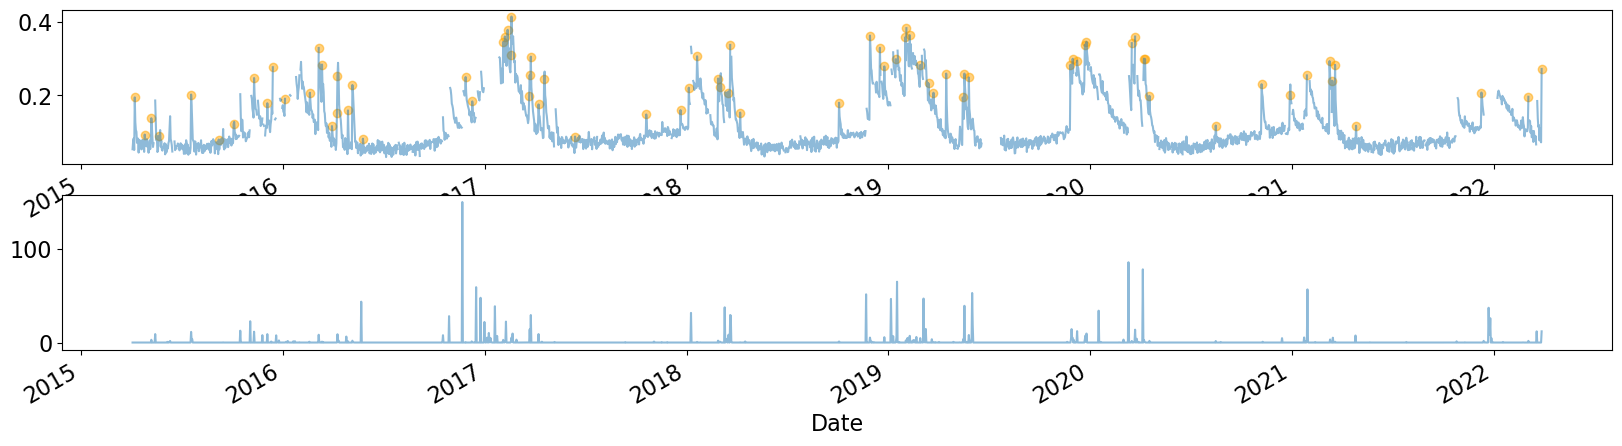

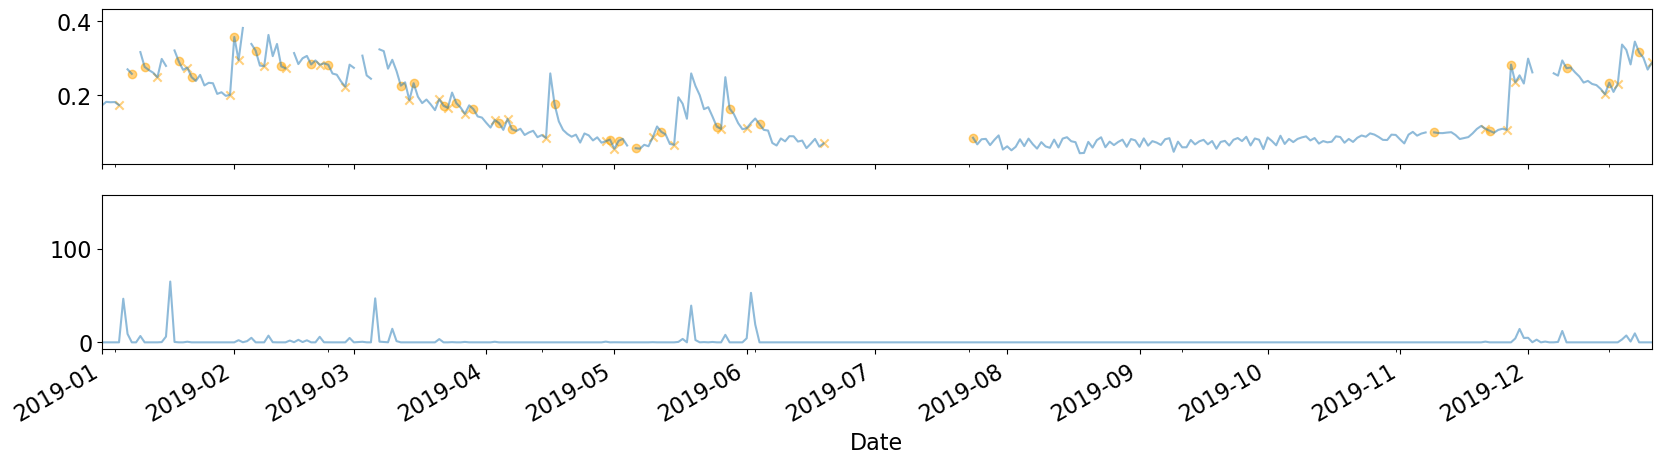

In [104]:
fig, (ax11, ax12) = plt.subplots(2,1, figsize=(20, 5))
ds_synced.soil_moisture_daily.plot(ax=ax11, alpha=0.5)
ax11.scatter(ds_synced.soil_moisture_daily[ds_synced['event_start']].index, ds_synced.soil_moisture_daily[ds_synced['event_start']].values, color='orange', alpha=0.5)
ds_synced.precip.plot(ax=ax12, alpha=0.5)

fig2, (ax21, ax22) = plt.subplots(2,1, figsize=(20, 5), sharex=True)
ds_synced.soil_moisture_daily.plot(ax=ax21, alpha=0.5)
# ax21.scatter(ds_synced.soil_moisture_daily[ds_synced['event_start']].index, ds_synced.soil_moisture_daily[ds_synced['event_start']].values, color='orange', alpha=0.5)
ax21.scatter(events_df.start, events_df.start_S, color='orange', alpha=0.5)
ax21.scatter(events_df.end, events_df.end_S, color='orange', marker='x', alpha=0.5)
ax21.set_xlim([datetime(2019, 1, 1), datetime(2019, 12, 30)])
ds_synced.precip.plot(ax=ax22, alpha=0.5)

## Plot

(17897.0, 18260.0)

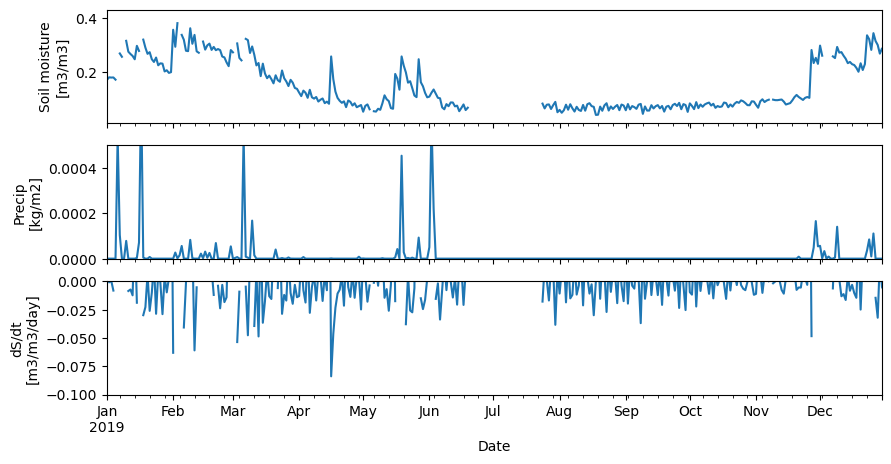

In [128]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 5), sharex=True)
ds_synced['soil_moisture_daily'].plot(ax=ax1)
ax1.set_ylabel('Soil moisture\n[m3/m3]')
ds_synced['precip'].plot(ax=ax2)
ax2.set_ylim([0, 0.0005])
ax2.set_ylabel('Precip\n[kg/m2]')
ds_synced['dSdt'].plot(ax=ax3)
ax3.set_ylabel('dS/dt\n[m3/m3/day]')
ax3.set_ylim([-0.1, 0])
ax1.set_xlim([datetime(2019, 1, 1), datetime(2019, 12, 30)])

Text(0, 0.5, 'dS/dt')

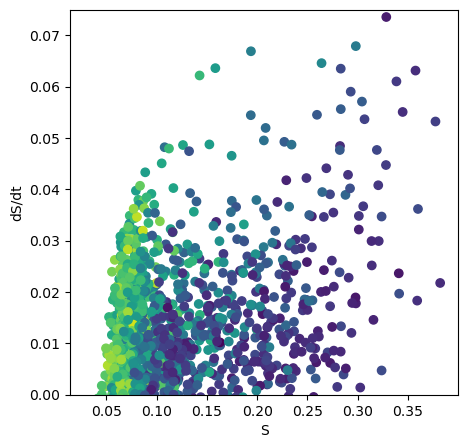

In [52]:
x1 = ds_synced.soil_moisture_daily.values
y1 = ds_synced.dSdt.values * -1
z1 = ds_synced.PET.values

fig, (ax3) = plt.subplots(1, 1, figsize=(5, 5))
high_diff_plot = ax3.scatter(x1, y1, c=z1, cmap='viridis')
ax3.set_ylim([0,0.075])
ax3.set_xlabel('S')
ax3.set_ylabel('dS/dt')

## Investigate on consective dSdt

In [54]:
ds_synced['dSdt']

Date
2015-04-03   -0.027751
2015-04-04    0.020496
2015-04-05    0.008755
2015-04-06   -0.031190
2015-04-07    0.142930
                ...   
2021-12-27         NaN
2021-12-28         NaN
2021-12-29         NaN
2021-12-30         NaN
2021-12-31         NaN
Name: dSdt, Length: 2465, dtype: float64

In [240]:
### Choose either dSdt or dSdt_allow_error ###
neg_mask = ds_synced['dSdt'] < 0
neg_mask

Date
2015-04-03     True
2015-04-04    False
2015-04-05    False
2015-04-06     True
2015-04-07    False
              ...  
2021-12-27    False
2021-12-28    False
2021-12-29    False
2021-12-30    False
2021-12-31    False
Name: dSdt, Length: 2465, dtype: bool

In [241]:
consec_neg_mask = neg_mask.ne(neg_mask.shift())
consec_neg_mask

Date
2015-04-03     True
2015-04-04     True
2015-04-05    False
2015-04-06     True
2015-04-07     True
              ...  
2021-12-27    False
2021-12-28    False
2021-12-29    False
2021-12-30    False
2021-12-31    False
Name: dSdt, Length: 2465, dtype: bool

In [242]:
event_num = consec_neg_mask.cumsum().where(neg_mask) 
event_num

Date
2015-04-03    1.0
2015-04-04    NaN
2015-04-05    NaN
2015-04-06    3.0
2015-04-07    NaN
             ... 
2021-12-27    NaN
2021-12-28    NaN
2021-12-29    NaN
2021-12-30    NaN
2021-12-31    NaN
Name: dSdt, Length: 2465, dtype: float64

In [243]:
ds_synced['event_num'] = event_num

In [244]:
grouped_dSdt = ds_synced.groupby('event_num')['dSdt'].apply(list)
grouped_dSdt_w_error = ds_synced.groupby('event_num')['dSdt_allow_error'].apply(list)
grouped_PET = ds_synced.groupby('event_num')['PET'].apply(list)
grouped_sm = ds_synced.groupby('event_num')['soil_moisture_daily'].apply(list)
grouped_precip = ds_synced.groupby('event_num')['precip'].apply(list)
ds_synced['time'] = ds_synced.index
grouped_time = ds_synced.groupby('event_num')['time'].apply(list)

In [245]:
grouped_dSdt = pd.DataFrame(grouped_dSdt)

In [246]:
grouped_datasets = grouped_dSdt.merge(grouped_PET, on='event_num', how='outer') \
               .merge(grouped_sm, on='event_num', how='outer') \
               .merge(grouped_precip, on='event_num', how='outer') \
               .merge(grouped_time, on='event_num', how='outer') \
            .merge(grouped_dSdt_w_error, on='event_num', how='outer')

In [247]:
grouped_datasets.head()

,dSdt,PET,soil_moisture_daily,precip,time,dSdt_allow_error
event_num,,,,,,
1.0,[-0.027751399999999996],[4.2659],[0.080593],[0.0],[2015-04-03 00:00:00],[-0.057751399999999994]
3.0,[-0.031189800000000004],[3.6549],[0.0820931],[0.0],[2015-04-06 00:00:00],[-0.0611898]
5.0,"[-0.0669091, -0.0217112, -0.004835800000000001...","[3.47952, 2.94221, 3.96109, 4.97817]","[0.1938336, 0.1269245, 0.1052133, 0.1003775]","[0.0, 0.0, 0.0, 0.0]","[2015-04-08 00:00:00, 2015-04-09 00:00:00, 201...","[-0.0969091, -0.0517112, -0.0348358, -0.0601742]"
7.0,[-0.037960999999999995],[5.18541],[0.0817556],[0.0],[2015-04-14 00:00:00],[-0.067961]
9.0,"[-0.019769299999999997, -0.0013203999999999994]","[4.96349, 4.90596]","[0.078025, 0.0582557]","[0.0, 0.0]","[2015-04-16 00:00:00, 2015-04-17 00:00:00]","[-0.049769299999999995, -0.0313204]"


In [248]:
grouped_datasets['length'] = grouped_datasets['dSdt'].apply(len)

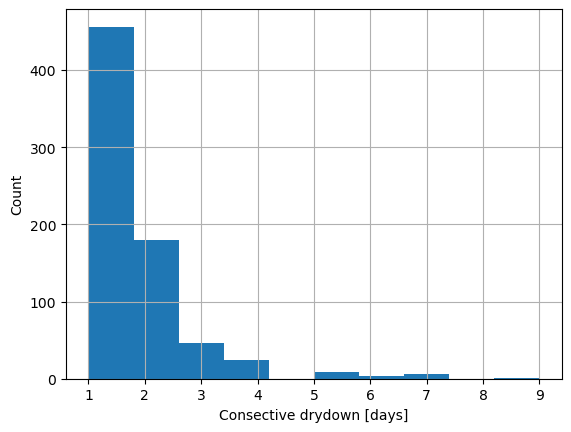

In [249]:
ax = grouped_datasets['length'].hist()

# add x and y labels
ax.set_xlabel('Consective drydown [days]')
ax.set_ylabel('Count')

plt.show()

In [250]:
exploded_df = grouped_datasets.explode(['dSdt', 'PET', 'soil_moisture_daily', 'precip', 'time', 'dSdt_allow_error'])
exploded_df.head(100)

,dSdt,PET,soil_moisture_daily,precip,time,dSdt_allow_error,length
event_num,,,,,,,
1.0,-0.027751,4.2659,0.080593,0.0,2015-04-03,-0.057751,1
3.0,-0.03119,3.6549,0.082093,0.0,2015-04-06,-0.06119,1
5.0,-0.066909,3.47952,0.193834,0.0,2015-04-08,-0.096909,4
5.0,-0.021711,2.94221,0.126924,0.0,2015-04-09,-0.051711,4
5.0,-0.004836,3.96109,0.105213,0.0,2015-04-10,-0.034836,4
...,...,...,...,...,...,...,...
137.0,-0.02695,1.91662,0.190179,0.0,2015-11-06,-0.05695,4
137.0,-0.009622,2.14162,0.163229,0.0,2015-11-07,-0.039622,4
137.0,-0.014725,2.09361,0.153607,0.0,2015-11-08,-0.044725,4


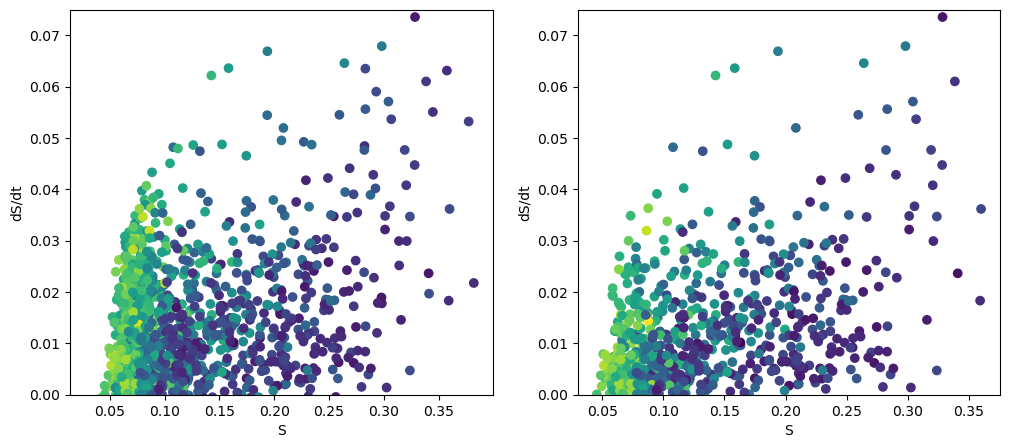

In [251]:
x1 = ds_synced.soil_moisture_daily.values
y1 = ds_synced.dSdt.values * -1
z1 = ds_synced.PET.values

length_thresh = 2

x2 = exploded_df.soil_moisture_daily[exploded_df['length']>=length_thresh].values
y2 = exploded_df.dSdt[exploded_df['length']>=length_thresh].values * -1
z2 = exploded_df.PET[exploded_df['length']>=length_thresh].values

fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 5))
high_diff_plot = ax3.scatter(x1, y1, c=z1, cmap='viridis')
ax3.set_ylim([0,0.075])
ax3.set_xlabel('S')
ax3.set_ylabel('dS/dt')

restricted_plot = ax4.scatter(x2, y2, c=z2, cmap='viridis')
ax4.set_ylim([0,0.075])
ax4.set_xlabel('S')
ax4.set_ylabel('dS/dt')

restricted_plot.colorbar




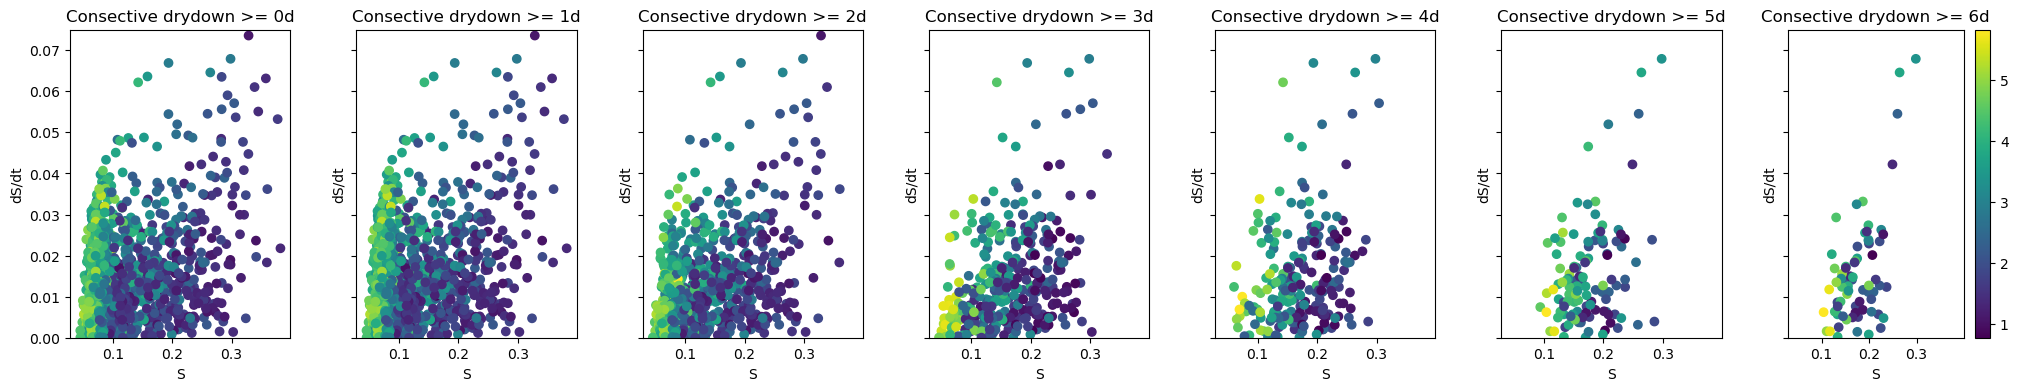

In [253]:
# create subplots for different values of length_thresh
fig, axs = plt.subplots(1, 7, figsize=(25, 4), gridspec_kw={'wspace': 0.3},sharex=True, sharey=True)


for i in range(0, 7):
    # length_thresh = i*10 + 1
    length_thresh = i

    x = exploded_df.soil_moisture_daily[exploded_df['length']>=length_thresh].values
    y = exploded_df.dSdt[exploded_df['length']>=length_thresh].values * -1
    z = exploded_df.PET[exploded_df['length']>=length_thresh].values
    
    sc = axs[i].scatter(x, y, c=z, cmap='viridis')
    axs[i].set_ylim([0, 0.075])
    axs[i].set_xlabel('S')
    axs[i].set_ylabel('dS/dt')
    axs[i].set_title(f'Consective drydown >= {length_thresh}d')


fig.colorbar(sc, ax=axs[6])


plt.tight_layout()
plt.show()


(17897.0, 18260.0)

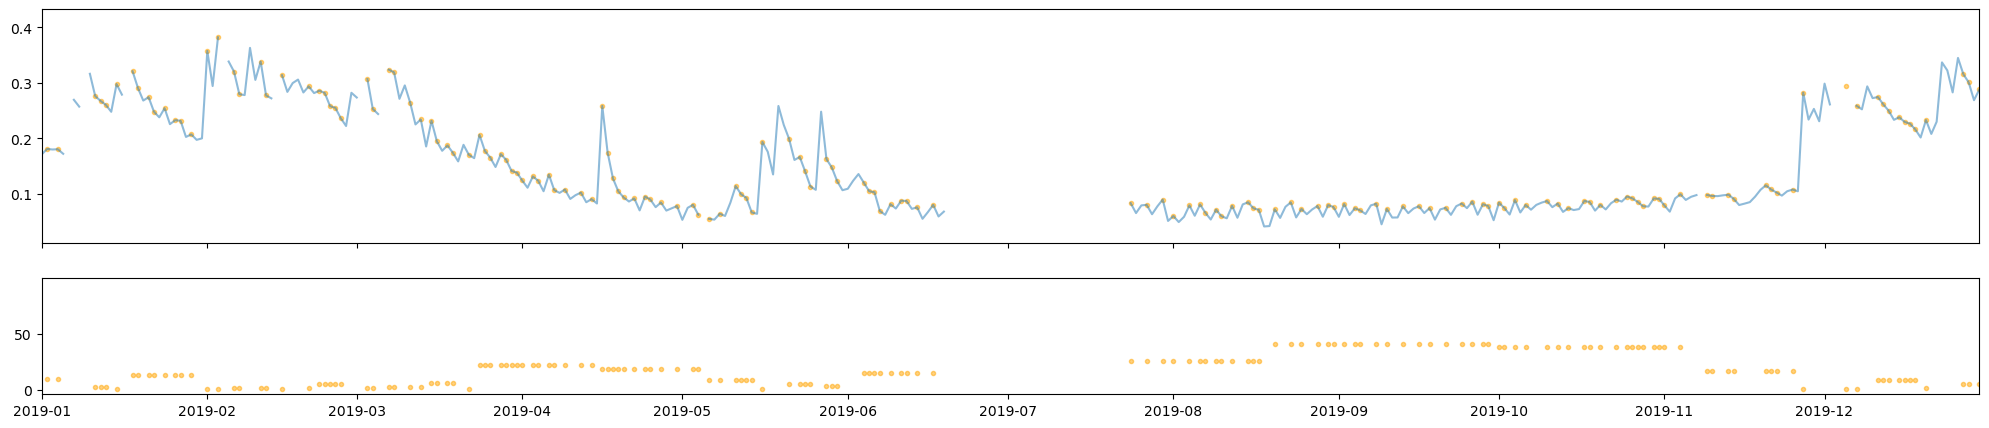

In [237]:
fig, axs = plt.subplots(2, 1, figsize=(25, 5), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
axs[0].plot(ds_synced.index, ds_synced.soil_moisture_daily, alpha=0.5)
axs[0].scatter(exploded_df[exploded_df['dSdt']<=0].time, exploded_df[exploded_df['dSdt']<=0].soil_moisture_daily, alpha=0.5, marker='.', color='orange')
axs[1].scatter(exploded_df[exploded_df['dSdt']<=0].time, exploded_df[exploded_df['dSdt']<=0].length, alpha=0.5, marker='.', color='orange')
axs[0].set_xlim([datetime(2019, 1|1, 1), datetime(2019, 12, 30)])

In [134]:
ds_synced['event_num'] = (ds_synced['dSdt'] > 0).cumsum() + (ds_synced['dSdt'].shift(1) < 0) & (ds_synced['dSdt'] < 0)

In [136]:
grouped_datasets2 = ds_synced.groupby('event_num')['dSdt'].apply(list).reset_index(name='dSdt_list')
grouped_datasets2.head()

,event_num,dSdt_list
0,False,"[-0.027751399999999996, 0.020496299999999995, ..."
1,True,"[-0.0669091, -0.037960999999999995, -0.0013203..."


In [138]:
recession_length = 1
len_decrease = int(recession_length / ((ds_synced.index[1] - ds_synced.index[0]).days))

In [143]:
eps = 0
decreasing_sm = ds_synced['soil_moisture_daily'][1:].values < (ds_synced['soil_moisture_daily'][:-1].values + eps)

In [144]:
decreasing_sm

array([ True, False, False, ..., False, False, False])